# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = 0.48866 CV = 0.463102
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML

Versão 1.0.1: LB = 0.48991 CV = 0.462946
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (com novas features)

Versão 1.0.2: LB = 0.48915 CV = 0.464442
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (com agrupamento pela coluna v2)

Versão 1.0.3: LB = 0.88299 CV = 0.344659
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado interno

Versão 1.0.4: LB = ???? CV = 0.461724
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (modificado v1)

# Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc
from scipy.stats import mstats

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier

# Importa pacotes do sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


Using TensorFlow backend.


# Carregando os dados de treino e teste

In [3]:
# Funcao de leitura dos dados
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino_modificado.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste_modificado.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [40]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 44 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 51 colunas


In [41]:
test = test[test.columns[:-8]]

In [42]:
# Juntando os dois dataset (treino e teste)
df = train.append(test)
df.shape

(228714, 44)

In [43]:
# Verificar a quantidade de features numericas e categoricas

numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  44
Number of Categorical features:  0


# Feature Engineering

In [44]:
new_df = df.copy()

In [45]:
new_df.head()

,target,v100,v101,v106,v107,v108,v10_bin,v110,v111,v112,v113,v125,v129,v14_bin,v22,v24,v26_bin,v28_bin,v3,v30,v31,v34_bin,v38,v46_bin,v47,v50,v52,v55_bin,v56,v57_bin,v58_bin,v62,v65_bin,v66,v67,v71,v72,v74,v79,v84,v85,v91,v94,v95
0,0.0,0.141689,0.386152,0.495177,0,0.131094,49,0,0.338176,0,0,0,0,45,0,0,122,175,0,0,0,141,0,251,0,0.111270,0,138,0,9,106,1,128,0,0.598997,0,1,0,0,0.139374,0.269716,0,0.281723,0.212921
1,1.0,0.000000,0.000000,0.000000,0,0.000000,61,0,0.000000,0,1,1,0,35,1,1,0,0,0,1,0,175,0,0,1,0.163392,1,0,1,0,0,1,0,1,0.000000,1,1,0,1,0.000000,0.000000,0,0.000000,0.000000
2,1.0,0.764561,0.233377,0.407940,0,0.135128,61,0,0.340090,1,0,2,0,58,2,2,30,175,0,-1,0,62,0,124,2,0.146414,0,138,2,21,54,1,37,0,0.441279,1,1,0,2,0.172676,0.328590,0,0.239724,0.163506
3,0.0,0.000000,0.000000,0.000000,1,0.000000,38,0,0.000000,2,0,3,0,43,3,1,0,0,0,-1,0,62,0,0,1,0.053418,2,0,-1,0,0,2,0,2,0.000000,1,2,0,3,0.000000,0.000000,1,0.000000,0.000000
4,1.0,0.973248,0.398321,0.612259,0,0.132526,55,1,0.236744,3,-1,4,0,137,4,0,54,69,0,-1,1,120,6,15,3,0.171427,3,32,3,61,22,0,151,1,0.506923,1,6,1,4,0.128673,0.114583,0,0.197568,0.170047


In [46]:
# Create correlation matrix
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['v106', 'v91', 'v95']

In [47]:
# Drop features 
new_df = new_df.drop(new_df[to_drop], axis=1)
new_df.shape

(228714, 41)

In [48]:
new_df.head()

,target,v100,v101,v107,v108,v10_bin,v110,v111,v112,v113,v125,v129,v14_bin,v22,v24,v26_bin,v28_bin,v3,v30,v31,v34_bin,v38,v46_bin,v47,v50,v52,v55_bin,v56,v57_bin,v58_bin,v62,v65_bin,v66,v67,v71,v72,v74,v79,v84,v85,v94
0,0.0,0.141689,0.386152,0,0.131094,49,0,0.338176,0,0,0,0,45,0,0,122,175,0,0,0,141,0,251,0,0.111270,0,138,0,9,106,1,128,0,0.598997,0,1,0,0,0.139374,0.269716,0.281723
1,1.0,0.000000,0.000000,0,0.000000,61,0,0.000000,0,1,1,0,35,1,1,0,0,0,1,0,175,0,0,1,0.163392,1,0,1,0,0,1,0,1,0.000000,1,1,0,1,0.000000,0.000000,0.000000
2,1.0,0.764561,0.233377,0,0.135128,61,0,0.340090,1,0,2,0,58,2,2,30,175,0,-1,0,62,0,124,2,0.146414,0,138,2,21,54,1,37,0,0.441279,1,1,0,2,0.172676,0.328590,0.239724
3,0.0,0.000000,0.000000,1,0.000000,38,0,0.000000,2,0,3,0,43,3,1,0,0,0,-1,0,62,0,0,1,0.053418,2,0,-1,0,0,2,0,2,0.000000,1,2,0,3,0.000000,0.000000,0.000000
4,1.0,0.973248,0.398321,0,0.132526,55,1,0.236744,3,-1,4,0,137,4,0,54,69,0,-1,1,120,6,15,3,0.171427,3,32,3,61,22,0,151,1,0.506923,1,6,1,4,0.128673,0.114583,0.197568


# Algoritmo LigthGBM com Hyperparametros

In [49]:
# Configurações Gerais

GENERATE_SUBMISSION_FILES = True
SUBMISSION_SUFIX = "_lgbm_v.1.0.4"
STRATIFIED_KFOLD = False
RANDOM_SEED = np.random.seed(123)
NUM_THREADS = 4
NUM_FOLDS = 10
EARLY_STOPPING = 1000

In [50]:
# Selecionando os melhores parametros
LIGHTGBM_PARAMS = {'boosting_type': 'gbdt', 
                  'colsample_bytree': 0.881783, 
                  'is_unbalance': False, 
                  'learning_rate': 0.0129388, 
                  'min_child_samples': 315, 
                  'num_leaves': 139, 
                  'reg_alpha': 0.484807, 
                  'reg_lambda': 0.515065, 
                  'subsample_for_bin': 280000, 
                  'subsample': 0.635119, 
                  'n_estimators': 10000
                 }

In [51]:
# ------------------------- LIGHTGBM MODEL -------------------------
# Funcao para processar todo o pipeline do treinamento e gerar a submissao
def run_model(dataset, categorical_feature = None):
    
    # Separar o dataset de treino e teste
    treino = dataset[dataset['target'].notnull()]
    teste  = dataset[dataset['target'].isnull()]
    
    # Separando features preditoras e target
    #X_ = treino.drop(['ID','target'], axis=1)
    X_ = treino.drop(['target'], axis=1)
    y_ = treino['target']
    
    # Aplicando a funcao SMOTE
    # SMOTE eh um metodo de oversampling. Ele cria exemplos sinteticos da classe minoritaria ao inves de criar copias
    #sm = SMOTE(random_state=0)
    #X, y = sm.fit_sample(X_, y_)

    X = X_.copy()
    y = y_.copy()
    
    # Padronizando os dados de treino
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    

    #del_features = ['ID','target']
    predictors = list(X_.columns)
    
    print("Train/valid shape: {}, test shape: {}".format(X.shape, y.shape))

    # Defini o tipo de Cross-Validation
    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(X.shape[0])
    sub_preds = np.zeros(teste.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
        train_x, train_y = X[train_idx], y[train_idx]
        valid_x, valid_y = X[valid_idx], y[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        
        if not categorical_feature:
            clf.fit(train_x, train_y, 
                    eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', 
                    verbose=100, 
                    early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, 
                    eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', 
                    verbose=100, 
                    early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(X_[predictors].columns), 
                    categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(teste.drop(['target'], axis=1), num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['binary_logloss']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['binary_logloss']

        print('Fold %2d Log Loss : %.6f' % (n_fold + 1, log_loss(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full Log Loss score %.6f' % log_loss(y, oof_preds))
    teste['target'] = sub_preds.copy()

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    
    # Save feature importance, test predictions and oof predictions as csv
    if GENERATE_SUBMISSION_FILES:

        # Save submission (test data) and feature importance
        submission = pd.read_csv('../dataset/sample_submission.csv')
        submission['PredictedProb'] = sub_preds.copy()
        submission.to_csv('../submission/submission{}.csv'.format(SUBMISSION_SUFIX), index=False)
        
        mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
        plt.hist(submission.PredictedProb)
        plt.show()

    
    return mean_importance

Train/valid shape: (114321, 40), test shape: (114321,)
Training until validation scores don't improve for 1000 rounds
[100]	training's binary_logloss: 0.471659	valid_1's binary_logloss: 0.487987
[200]	training's binary_logloss: 0.451571	valid_1's binary_logloss: 0.4756
[300]	training's binary_logloss: 0.439787	valid_1's binary_logloss: 0.472256
[400]	training's binary_logloss: 0.429302	valid_1's binary_logloss: 0.470698
[500]	training's binary_logloss: 0.419902	valid_1's binary_logloss: 0.470268
[600]	training's binary_logloss: 0.411226	valid_1's binary_logloss: 0.469805
[700]	training's binary_logloss: 0.403147	valid_1's binary_logloss: 0.469435
[800]	training's binary_logloss: 0.395682	valid_1's binary_logloss: 0.469299
[900]	training's binary_logloss: 0.388608	valid_1's binary_logloss: 0.469094
[1000]	training's binary_logloss: 0.381862	valid_1's binary_logloss: 0.468868
[1100]	training's binary_logloss: 0.375397	valid_1's binary_logloss: 0.468798
[1200]	training's binary_logloss: 0

[1100]	training's binary_logloss: 0.375949	valid_1's binary_logloss: 0.46435
[1200]	training's binary_logloss: 0.369682	valid_1's binary_logloss: 0.464183
[1300]	training's binary_logloss: 0.363733	valid_1's binary_logloss: 0.464063
[1400]	training's binary_logloss: 0.357868	valid_1's binary_logloss: 0.463891
[1500]	training's binary_logloss: 0.352251	valid_1's binary_logloss: 0.463797
[1600]	training's binary_logloss: 0.346797	valid_1's binary_logloss: 0.46368
[1700]	training's binary_logloss: 0.34152	valid_1's binary_logloss: 0.4637
[1800]	training's binary_logloss: 0.336442	valid_1's binary_logloss: 0.46384
[1900]	training's binary_logloss: 0.33152	valid_1's binary_logloss: 0.463889
[2000]	training's binary_logloss: 0.32665	valid_1's binary_logloss: 0.463903
[2100]	training's binary_logloss: 0.321986	valid_1's binary_logloss: 0.464101
[2200]	training's binary_logloss: 0.317408	valid_1's binary_logloss: 0.464293
[2300]	training's binary_logloss: 0.312951	valid_1's binary_logloss: 0.4

[1000]	training's binary_logloss: 0.382093	valid_1's binary_logloss: 0.465762
[1100]	training's binary_logloss: 0.375642	valid_1's binary_logloss: 0.465734
[1200]	training's binary_logloss: 0.369362	valid_1's binary_logloss: 0.465671
[1300]	training's binary_logloss: 0.363405	valid_1's binary_logloss: 0.465787
[1400]	training's binary_logloss: 0.357626	valid_1's binary_logloss: 0.465925
[1500]	training's binary_logloss: 0.352087	valid_1's binary_logloss: 0.466184
[1600]	training's binary_logloss: 0.346694	valid_1's binary_logloss: 0.466503
[1700]	training's binary_logloss: 0.341516	valid_1's binary_logloss: 0.466767
[1800]	training's binary_logloss: 0.336367	valid_1's binary_logloss: 0.467035
[1900]	training's binary_logloss: 0.331317	valid_1's binary_logloss: 0.46715
Early stopping, best iteration is:
[937]	training's binary_logloss: 0.386309	valid_1's binary_logloss: 0.465657
Fold  9 Log Loss : 0.465657
Training until validation scores don't improve for 1000 rounds
[100]	training's b

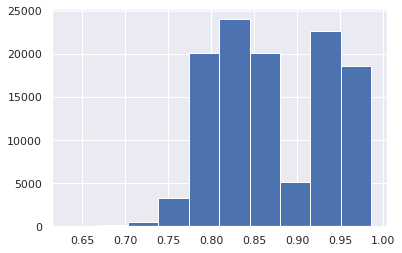

,feature,gain,split
23,v50,375668.418239,14730.1
31,v66,106722.038591,2950.9
26,v56,67105.880259,8955.5
18,v31,66532.364682,482.0
12,v22,62836.764023,13525.1
19,v34_bin,61505.875440,7959.1
5,v110,47994.083201,1022.9
9,v125,46232.333444,9738.1
4,v10_bin,46169.867209,8152.6
11,v14_bin,36342.509342,7387.6


In [52]:
run_model(new_df)